In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.offline as po 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

C:\Users\Umberto\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: No module named 'xgboost'

In [8]:
df = pd.read_csv("train.csv")

# Data Understanding

In [3]:
df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [9]:
print(len(df.Patient_ID.unique())) #Check if Patient_ID can be used as index
df = df.set_index("Patient_ID")

900


In [26]:
df.describe()

,Family_Case_ID,Severity,Birthday_year,Parents or siblings infected,Wife/Husband or children infected,Medical_Expenses_Family,Deceased
count,900.000000,900.000000,723.000000,900.000000,900.000000,900.000000,900.000000
mean,14305.827778,2.313333,1990.266943,0.380000,0.521111,895.743333,0.614444
std,25418.153900,0.834223,14.523335,0.803247,1.098385,1385.829926,0.486997
min,345.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,0.000000
25%,8203.000000,2.000000,1982.000000,0.000000,0.000000,221.000000,0.000000
50%,13593.500000,3.000000,1992.000000,0.000000,0.000000,405.000000,1.000000
75%,18906.500000,3.000000,1999.500000,0.000000,1.000000,861.250000,1.000000
max,742836.000000,3.000000,2019.000000,6.000000,8.000000,14345.000000,1.000000


Seen the describe, I understood that it was useful doing the boxplot only at medical exepnses and birthday year to see possible outliers. The others doesn't seem to have weird values. 

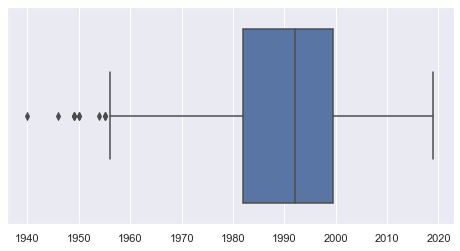

In [11]:
# Boxplot age 
sns.boxplot(x=df[['Birthday_year']])

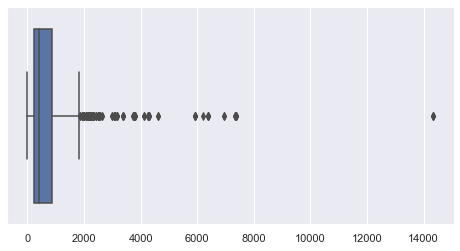

In [12]:
# Boxplot Medical expenses
sns.boxplot(x=df[['Medical_Expenses_Family']])

In [5]:
# Number of Nan values 
df.isna().sum()

Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

There are a lot of medical tent nan values. Medical tent it is basically the tent where the patient has been cured.. don't know how useful it is.. 


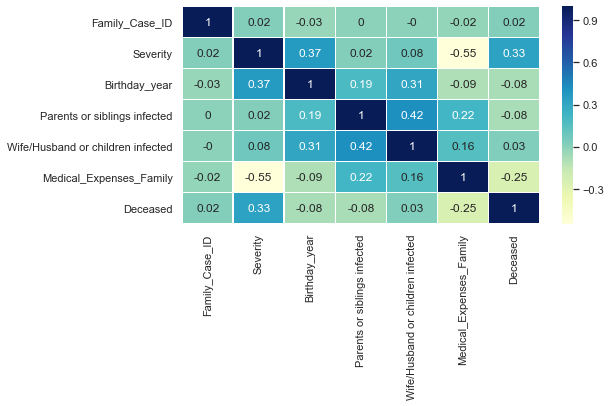

In [6]:
# Creating the correlation matrix 
pearson_corr_matrix=df.corr('pearson').round(decimals=2)
sns.set(rc={'figure.figsize':(8,4)})
sns.heatmap(pearson_corr_matrix,
        xticklabels=pearson_corr_matrix.columns,
        yticklabels=pearson_corr_matrix.columns, annot=True, linewidths=.5, cmap="YlGnBu")


Pretty weird the fact that there's an high negative correlation between medical expenss and severity.. I would have thought the contrary, the most is severe the most on meds you would spend. Normal to see birthday year and severity in positive correlation and the same for parents or sibilings and wife/husband. 

In [28]:
numerical_var = ["Severity","Parents or siblings infected", "Wife/Husband or children infected", "Medical_Expenses_Family"]

In [7]:
# Histograms for all numeric variables
df[numerical_var].hist(bins=15, layout=(2, 2), xlabelsize=8, ylabelsize=8);

NameError: name 'numerical_var' is not defined

In [8]:
# Family sizes
print(len(df.Family_Case_ID.unique()))
pd.Series(df.Family_Case_ID.value_counts()).value_counts()

675


1    530
2    102
3     24
4     10
7      3
6      3
5      3
Name: Family_Case_ID, dtype: int64

Text(0, 0.5, 'Frequency')

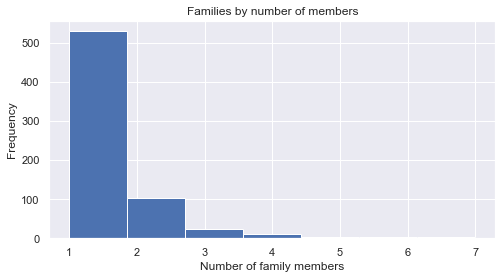

In [9]:
# Plotting how big the family are, most of them just 1/2
families = df.groupby(["Family_Case_ID"])["Family_Case_ID"].count().reset_index(name='count').sort_values(by='count')

ax = families.plot(x='Family_Case_ID', y ='count' , kind="hist",legend= False, title = "Families by number of members",bins=7)
ax.set_xlabel("Number of family members")
ax.set_ylabel("Frequency")

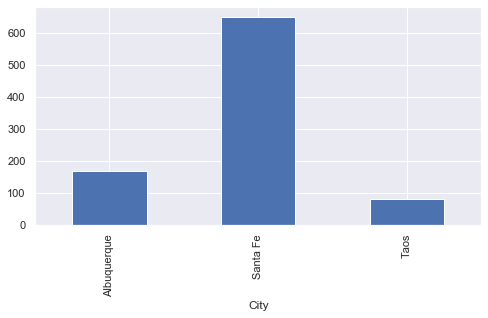

In [13]:
# Deaths by city
df.groupby(['City'])['Deceased'].count().reset_index(name='deaths').plot(kind='bar',x='City',legend=False)

Text(0, 0.5, 'Number of deceased')

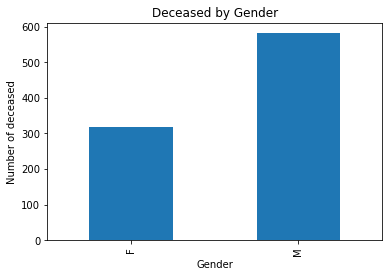

In [10]:
# Deaths by gender 

df['Name'].str.rsplit(' ', n=2, expand=True)[0].value_counts()
gender = {'Mr.':"M",'Ms.':"F",'Master':"M",'Miss':"F"}
df['Name'] = df['Name'].str.rsplit(' ', n=0, expand=True)
df['Name'] = [gender[item] for item in df['Name']]
df.rename(columns = {'Name':'Gender'},inplace=True)

ax = df.groupby(['Gender'])['Deceased'].count().plot(kind='bar',x='City',legend= False,title='Deceased by Gender')
ax.set_ylabel('Number of deceased')


# Data Preparation

# Feature Engineering & Selection

# Modeling